In [1]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os 
import csv
import psycopg2 
import json
import re
import matplotlib.pyplot as plt
from collections import Counter
import ast
from typing import TypedDict
load_dotenv()

URL_DB = os.environ.get("URL_DB")
CONN = psycopg2.connect(URL_DB)
CURSOR = CONN.cursor()

In [2]:
# TODO: ADD THIS COLUMN TO MAIN JOBS. 
## UPDATE THE PSYCOPG2 FUNCTIONS THAT SEND TO POSTGRE.
## REMEMBER THAT THIS IS A BREAKING CHANGE IN ROLEHOUNDS. UPDATE THAT AS WELL.
## 

timestamp = "2024-05-01 00:00:00.000000"

CURSOR.execute(
	f"SELECT location FROM main_jobs  WHERE timestamp > '{timestamp}'"
)
new_data = CURSOR.fetchall()
df = pd.DataFrame(new_data)

df.rename(columns={0: "location"}, inplace=True)



In [3]:
def load_json_file(file_path: str):
	with open(file_path, 'r') as file:
		return json.load(file)

def save_json_file(data: dict, file_path: str) -> None:
	with open(file_path, 'w') as file:
		json.dump(data, file, indent=4)

In [4]:


def transform_data(input_data: dict) -> dict[str, dict[str, list[dict[str, list[str]]]]]:
	"""Simplify the data structure of 'all_locations.json' for better and easier mapping"""
	result = {}
	for continent, data in input_data.items():
		result[continent] = {"Countries": []}
		for country in data["Countries"]:
			country_name: str = country["country_name"].upper()
			country_code = country["country_code"].upper()
			if country["capital_english"] != "NaN":
				capital_english = country["capital_english"].upper()
			
			subdivisions = []
			if isinstance(country["subdivisions"], list):
				subdivisions = [sub["subdivisions_name"].upper() for sub in country["subdivisions"]]
			elif country["subdivisions"] != "NaN":
				subdivisions = [country["subdivisions"].upper()]
			
			transformed_country = {
				country_name: [country_code, capital_english] + subdivisions
			}
			result[continent]["Countries"].append(transformed_country)
	
	return result

#Example usage:

"""
input_file = "/root/JobsCrawler/src/notebooks/all_locations.json"
output_file = "/root/JobsCrawler/src/notebooks/all_locations_transformed.json"

input_data = load_json_file(input_file)
transformed_data = transform_data(input_data)
save_json_file(transformed_data, output_file)

print("Data transformation complete. Result saved to", output_file)
"""

'\ninput_file = "/root/JobsCrawler/src/notebooks/all_locations.json"\noutput_file = "/root/JobsCrawler/src/notebooks/all_locations_transformed.json"\n\ninput_data = load_json_file(input_file)\ntransformed_data = transform_data(input_data)\nsave_json_file(transformed_data, output_file)\n\nprint("Data transformation complete. Result saved to", output_file)\n'

In [5]:

df['original_index'] = df.index

df['location'] = df['location'].astype(str)

df["location"] = df["location"].str.replace(",", "", regex=False).str.replace(")", "", regex=False).str.replace("(", "", regex=False).str.replace("|", " ", regex=False)

df["location"] = df["location"].str.strip().str.split()
df = df.explode("location").reset_index(drop=True)

df.head(25)

df.to_csv("/root/JobsCrawler/src/notebooks/all_location_words.csv")


In [6]:
# Get all unique words
unique_words = df["location"].unique()

# Create a new DataFrame with these unique words
unique_words_df = pd.DataFrame({"unique_word": unique_words})


unique_words_df.to_csv("/root/JobsCrawler/src/notebooks/unique_words.csv")



## naive approach

In [7]:


## TODO: AS SOME LOCATIONS CONTAIN MORE THAN A WORD, IT SHOULD ADD THE NEXT WORD IF THE RESULT IS UNKNOWN, AND IF THEIR INDEX ARE THE SAME. ELSE FINALLY ASSING UNKNOWN AGAIN. MAKE A FUNCTION THAT CONCATENATES THE WORD THAT COULD NOT BE FOUND IN LOC.LOWER AND ADD ITS NEXT WORD ONLY IF THEIR INDEX ARE EQUAL. FOR EXAMPLE, THIS FUNCTION WOULD NOT MATCH THE WORD "SAN" BUT IF WE DO THIS, THEN THE CONCATENATED STRING WOULD BE "SAN FRANCISCO", WHICH SHOULD FIND ITS MATCH.

"""

def add_location_tags(df: pd.DataFrame, json_file_path: str) -> pd.DataFrame:
	location_data = load_json_file(json_file_path)
	def find_location_tag(word: str) -> str | float:
			word_str = str(word)
			for continent, countries in location_data.items():
				for country in countries['Countries']:
					for country_name, locations in country.items():
						for loc in locations:
							if word_str.lower() in loc.lower():
								return country_name
						if word_str.lower() == country_name.lower():
							return country_name
				if word_str.lower() == continent.lower():
					return continent
			return np.nan
	df['location_tag'] = df[0].apply(find_location_tag)
	return df

json_file_path = '/root/JobsCrawler/src/notebooks/all_locations_transformed.json'
result2_df = add_location_tags(df, json_file_path)
print(result2_df)

result2_df.to_csv("/root/JobsCrawler/src/notebooks/country_mapping.csv")

nan_count_per_column = result2_df.isna().sum()

print("nan_count_per_column", nan_count_per_column)

"""

'\n\ndef add_location_tags(df: pd.DataFrame, json_file_path: str) -> pd.DataFrame:\n\tlocation_data = load_json_file(json_file_path)\n\tdef find_location_tag(word: str) -> str | float:\n\t\t\tword_str = str(word)\n\t\t\tfor continent, countries in location_data.items():\n\t\t\t\tfor country in countries[\'Countries\']:\n\t\t\t\t\tfor country_name, locations in country.items():\n\t\t\t\t\t\tfor loc in locations:\n\t\t\t\t\t\t\tif word_str.lower() in loc.lower():\n\t\t\t\t\t\t\t\treturn country_name\n\t\t\t\t\t\tif word_str.lower() == country_name.lower():\n\t\t\t\t\t\t\treturn country_name\n\t\t\t\tif word_str.lower() == continent.lower():\n\t\t\t\t\treturn continent\n\t\t\treturn np.nan\n\tdf[\'location_tag\'] = df[0].apply(find_location_tag)\n\treturn df\n\njson_file_path = \'/root/JobsCrawler/src/notebooks/all_locations_transformed.json\'\nresult2_df = add_location_tags(df, json_file_path)\nprint(result2_df)\n\nresult2_df.to_csv("/root/JobsCrawler/src/notebooks/country_mapping.csv")\

## sliding window approach

In [8]:

class Countries(TypedDict):
	country_name: str
	locations: list[str]

class WorldLocations(TypedDict):
	continent: str
	areas: list[str]
	countries: list[Countries]




def find_location_tag(word: str, location_data: WorldLocations) -> str:
	word_upper = word.upper()
	for continent, countries in location_data.items():
		if word_upper == continent.upper():
			return word_upper
		for zone in countries['Zones']:
			if word_upper == zone:
				return word_upper
		for country in countries['Countries']:
			for country_name, locations in country.items():
				if word_upper == country_name or word_upper in [loc for loc in locations]:
					return country_name
	return ""

def add_location_tags(df: pd.DataFrame, json_file_path: str) -> pd.DataFrame:
	location_data = load_json_file(json_file_path)
	result = []
	i = 0
	while i < len(df):
		current_word = str(df.iloc[i, 0])
		current_original_index = df.loc[i, "original_index"]
		
		tag = find_location_tag(current_word, location_data)
		
		if tag:
			result.append(tag)
			i += 1
		else:
			# If no match, try to concatenate with the next word if it has the same original_index
			if i + 1 < len(df) and df.loc[i + 1, "original_index"] == current_original_index:
				next_word = str(df.iloc[i + 1, 0])
				compound_word = f"{current_word} {next_word}"
				tag = find_location_tag(compound_word, location_data)
				
				if tag:
					result.extend([tag, tag])
					i += 2
				else:
					result.append(np.nan)
					i += 1
			else:
				result.append(np.nan)
				i += 1

	df['location_tag'] = result
	return df

json_file_path = '/root/JobsCrawler/src/notebooks/all_locations_transformed.json'
result_df = add_location_tags(df, json_file_path)
print(result_df)

result_df.to_csv("/root/JobsCrawler/src/notebooks/country_mapping1.csv")
nan_count_per_column = result_df.isna().sum()


        location  original_index    location_tag
0         Canada               0          CANADA
1         Canada               1          CANADA
2         Remote               2             NaN
3         Hybrid               2             NaN
4         Remote               2             NaN
...          ...             ...             ...
59694       Hong           12484           CHINA
59695       Kong           12484           CHINA
59696  Worldwide           12485        ANYWHERE
59697     United           12486  UNITED KINGDOM
59698    Kingdom           12486  UNITED KINGDOM

[59699 rows x 3 columns]


In [9]:

nan_count_per_column = result_df.isna().sum()

print(nan_count_per_column)


location            129
original_index        0
location_tag      18233
dtype: int64


### GROUPED WORDS BACK

In [11]:

def clean_and_split(s):
	# Remove brackets and split by comma
	tags = re.findall(r"'([^']*)'", s)
	return tags

#result_df = result_df.dropna(subset=['location_tag'])
result_df['location'] = result_df['location'].astype(str)

result_df['location_tag'] = result_df['location_tag'].fillna('NaN')

# Group by original_index and aggregate the locations and tags
grouped = result_df.groupby('original_index').agg({
    'location': lambda x: ' '.join(x),
    'location_tag': lambda x: ''.join(str(x.unique()))
})

# Reset the index to make original_index a column again
grouped = grouped.reset_index()

# Clean up the location column
grouped['location'] = grouped['location'].apply(lambda x: re.sub(r"[\[\]']", "", x))
grouped['location_tag'] = grouped['location_tag'].apply(clean_and_split)

# Sort by original_index to maintain the original order
grouped = grouped.sort_values('original_index')

# Drop the original_index column
grouped = grouped.drop('original_index', axis=1)

# Reset index after sorting and dropping column
grouped = grouped.reset_index(drop=True)

grouped.head(40)

,location,location_tag
0,Canada,[CANADA]
1,Canada,[CANADA]
2,Remote Hybrid Remote,[NaN]
3,Na N,[NaN]
4,Na N,[NaN]
5,Na N,[NaN]
6,Worldwide,[ANYWHERE]
7,Worldwide,[ANYWHERE]
8,Remote USA Europe remote Remote,"[NaN, UNITED STATES, EUROPE]"
9,India,[INDIA]


#### Plot it 

['CANADA', 'CANADA', 'NaN', 'NaN', 'NaN', 'NaN', 'ANYWHERE', 'ANYWHERE', 'NaN', 'UNITED STATES', 'EUROPE', 'INDIA', 'MEXICO', 'GERMANY', 'UNITED STATES', 'ANYWHERE', 'CANADA', 'NaN', 'UNITED STATES', 'NaN', 'ANYWHERE', 'ANYWHERE', 'ANYWHERE', 'UNITED STATES', 'NaN', 'UNITED STATES', 'NaN', 'CANADA', 'SUDAN', 'NaN', 'UNITED STATES', 'NaN', 'MEXICO', 'EMEA', 'EMEA', 'NaN', 'ANYWHERE', 'LATAM', 'NaN', 'COLOMBIA', 'INDIA', 'CANADA', 'NaN', 'UNITED STATES', 'NaN', 'NaN', 'INDIA', 'NaN', 'UNITED STATES', 'NaN', 'CANADA', 'UNITED STATES', 'NaN', 'UNITED STATES', 'NaN', 'ANYWHERE', 'NaN', 'UNITED STATES', 'LATAM', 'NaN', 'BRAZIL', 'LATAM', 'NaN', 'ARGENTINA', 'POLAND', 'NaN', 'COLOMBIA', 'LATAM', 'LATAM', 'NaN', 'ARGENTINA', 'LATAM', 'NaN', 'ARGENTINA', 'CANADA', 'NaN', 'NORTH MACEDONIA', 'LATAM', 'NaN', 'BRAZIL', 'LATAM', 'NaN', 'LATAM', 'NaN', 'COSTA RICA', 'LATAM', 'NaN', 'LATAM', 'NaN', 'LATAM', 'NaN', 'BRAZIL', 'NaN', 'UNITED STATES', 'NaN', 'UNITED STATES', 'NaN', 'UNITED STATES', 'NaN',

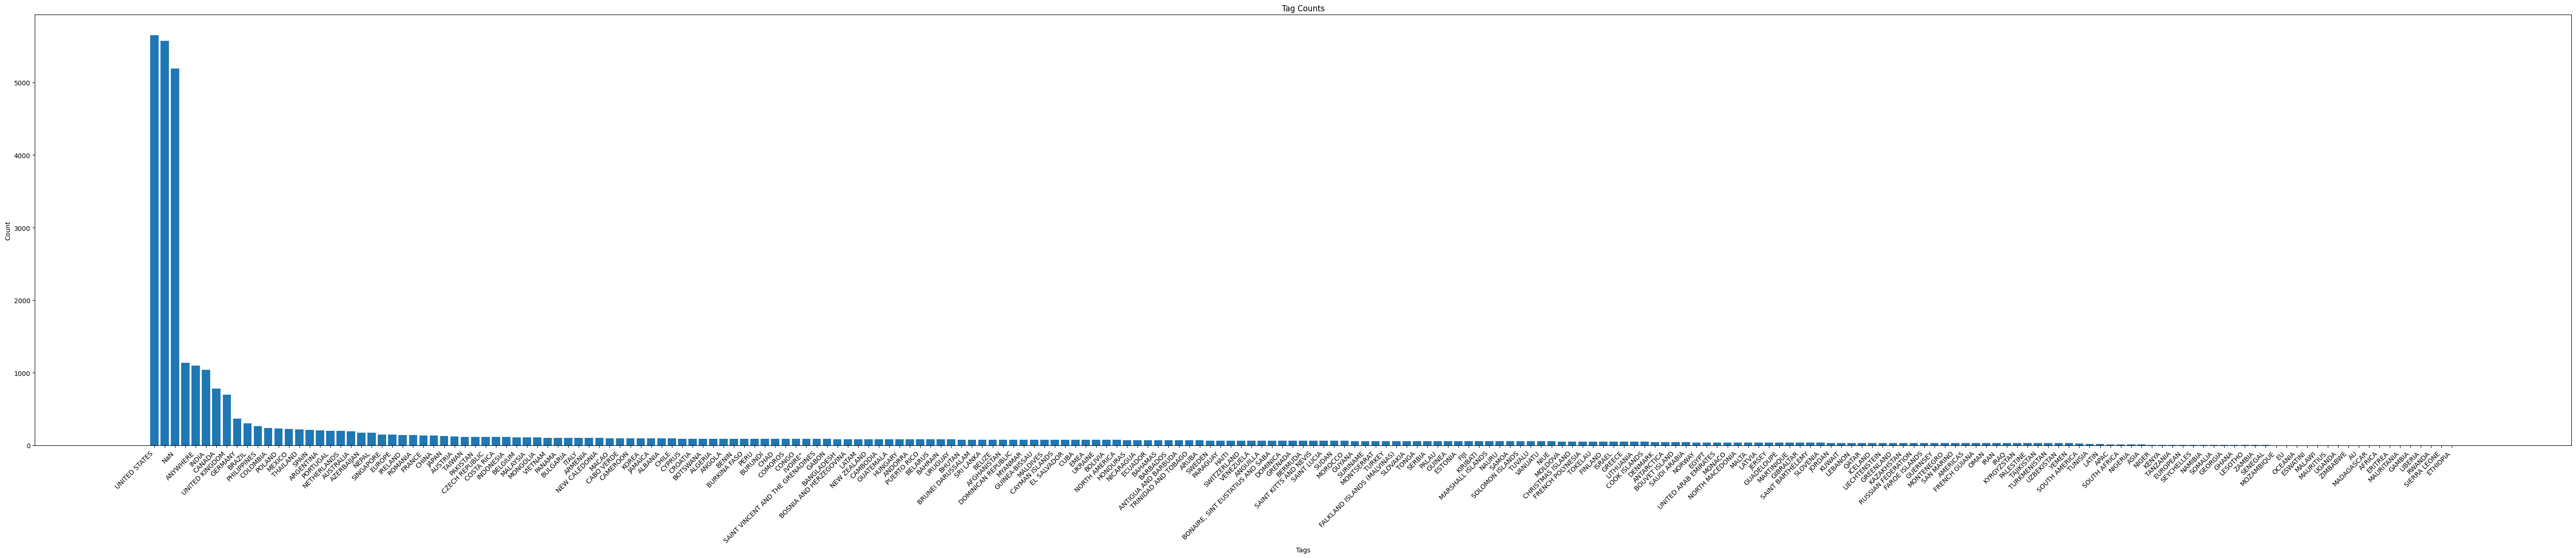

In [12]:

all_tags = grouped['location_tag'].explode().tolist()

print(all_tags)

# Count the tags
tag_counts = Counter(all_tags)

# Sort tags by count in descending order
sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)

# Separate tags and counts for plotting
tags, counts = zip(*sorted_tags)

# Create a bar plot
plt.figure(figsize=(55, 12))
plt.bar(tags, counts)
plt.title('Tag Counts')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

# Return the tag counts dictionary


## do the same but for the unique words. To see all the words that are not currently mapped

In [ ]:

def simple_add_location_tags(df: pd.DataFrame, json_file_path: str) -> pd.DataFrame:
	location_data = load_json_file(json_file_path)
	result = []
	i = 0
	while i < len(df):
		current_word = str(df.iloc[i, 0])
		
		tag = find_location_tag(current_word, location_data)
		
		if tag:
			result.append(tag)
		else:
			result.append(np.nan)
		
		i += 1

	df['location_tag'] = result
	return df

json_file_path = '/root/JobsCrawler/src/notebooks/all_locations_transformed.json'


unique_mapped_words_df = simple_add_location_tags(unique_words_df, json_file_path)

unique_mapped_words_df.to_csv("/root/JobsCrawler/src/notebooks/unique_word_mapping.csv")


unique_mapped_words_df


In [ ]:
unique_mapped_words_df


In [ ]:
nan_count_per_column = unique_mapped_words_df.isna().sum()

print(nan_count_per_column)